In [1]:
import os
import sys
from importlib import reload
from pathlib import Path

import numpy as np
import torch
from torch.nn import ReLU, Linear, Dropout
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, GraphConv
from torch import from_numpy
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# NOTE: Boilerplate setup for Jupyter imports

root = Path(os.getcwd()).parent
sys.path.append(
    (root / "src").as_posix()
)

import schema.configs as config_module
import enhancer as enhancer_module
import strategies as encoders_module
import schema.task as edges_module
import schema.data as data_module
import utils.metrics as utils_module

reload(edges_module)
reload(config_module)
reload(enhancer_module)
reload(encoders_module)
reload(data_module)
reload(utils_module)

PathConfig, TrainConfig, NetworkConfig = config_module.PathConfig, config_module.TrainConfig, config_module.NetworkConfig
Enhancer = enhancer_module.Enhancer
get_default_encoders = encoders_module.get_default_encoders
EnhancerData = data_module.EnhancerData
GraphSetup = edges_module.Task
euclid_metric, haversine_metric = utils_module.euclid_dist, utils_module.haversine_dist

In [3]:
DATASET = "melbourne"

In [4]:
path_config = PathConfig(data_root="../data")
path_config.target_data = path_config.data_root / f"processed/np/{DATASET}.npz"

In [5]:
with open(path_config.target_data, "rb") as f:
    unpacked = np.load(f)
    data, target, spatial = unpacked["data"], unpacked["target"], unpacked["spatial"]

In [6]:
scaler = StandardScaler()
spatial_processed = scaler.fit_transform(spatial)

In [7]:
train_data, test_data, train_target, test_target, train_spatial, test_spatial, train_spatial_pcs, test_spatial_pcs = (
    train_test_split(data, target, spatial, spatial_processed, test_size=0.2)
)

train_data, val_data, train_target, val_target, train_spatial, val_spatial, train_spatial_pcs, val_spatial_pcs = (
    train_test_split(train_data, train_target, train_spatial, train_spatial_pcs, test_size=0.125)
)

In [8]:
print(
    train_data.shape[0] / data.shape[0],
    test_data.shape[0] / data.shape[0],
    val_data.shape[0] / data.shape[0],
)

0.6999532880053978 0.2000311413297348 0.1000155706648674


## Fixed network architecture

In [9]:
HIDDEN = [128, 128, 64] # MLP architecture (inpput layer of size N_features and output of size 1 will be added dynamically)
ACTIVATION_T = ReLU

LOSS = torch.nn.MSELoss()
LR = 5e-4
BATCH_SIZE = 128
EPOCHS = 100

## Classical DL

In [10]:
X_train, y_train = (
    torch.from_numpy(
        # np.hstack((train_data, train_spatial_pcs)).astype(np.float32)
        train_data.astype(np.float32)
    ),
    torch.from_numpy(train_target.astype(np.float32)),
)

X_test, y_test = (
    torch.from_numpy(
        # np.hstack((test_data, test_spatial_pcs)).astype(np.float32)
        test_data.astype(np.float32)
    ),
    torch.from_numpy(test_target.astype(np.float32)),
)

X_val, y_val = (
    torch.from_numpy(
        # np.hstack((val_data, val_spatial_pcs)).astype(np.float32)
        val_data.astype(np.float32)
    ),
    torch.from_numpy(val_target.astype(np.float32)),
)

In [11]:
class Model(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()

        layers = []
        tmp = [input_dim, *HIDDEN, output_dim]

        for layer_in, layer_out in zip(tmp, tmp[1:]):
            layers.append(Linear(layer_in, layer_out))
            layers.append(ACTIVATION_T())

        self.hidden = torch.nn.Sequential(*layers[:-1])

    def forward(self, x: torch.Tensor):
        return self.hidden(x)

In [12]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=BATCH_SIZE,
)

model = Model(X_train.shape[1], 1)
optim = torch.optim.Adam(model.parameters(), lr=LR)

In [13]:
train_logs = []

pbar = tqdm(range(EPOCHS), desc="DL training", unit="epoch")
for _ in pbar:
    model.train()
    total_train_loss = 0

    for b_data, b_target in train_loader:
        optim.zero_grad()
        output = model(b_data)

        loss = LOSS(output.squeeze(), b_target.squeeze())
        loss.backward()
        optim.step()
        total_train_loss += loss.item() * b_data.shape[0]

    model.eval()
    with torch.no_grad():
        output = model(X_val)
        val_loss = mean_squared_error(y_val.squeeze(), output.squeeze())
        pbar.set_postfix(val_loss=val_loss)

        train_logs.append((
            total_train_loss / X_train.shape[0],
            val_loss
        ))

DL training: 100%|██████████| 100/100 [00:24<00:00,  4.13epoch/s, val_loss=9.05e+10]


In [14]:
with torch.no_grad():
    test_output = model(X_test)
    mse = mean_squared_error(y_test.squeeze(), test_output.squeeze())
    r2 = r2_score(y_test.squeeze(), test_output.squeeze())

    print(f"FINAL: MSE = {mse:.3E} || R2 = {r2:.3f}")

FINAL: MSE = 9.024E+10 || R2 = 0.680


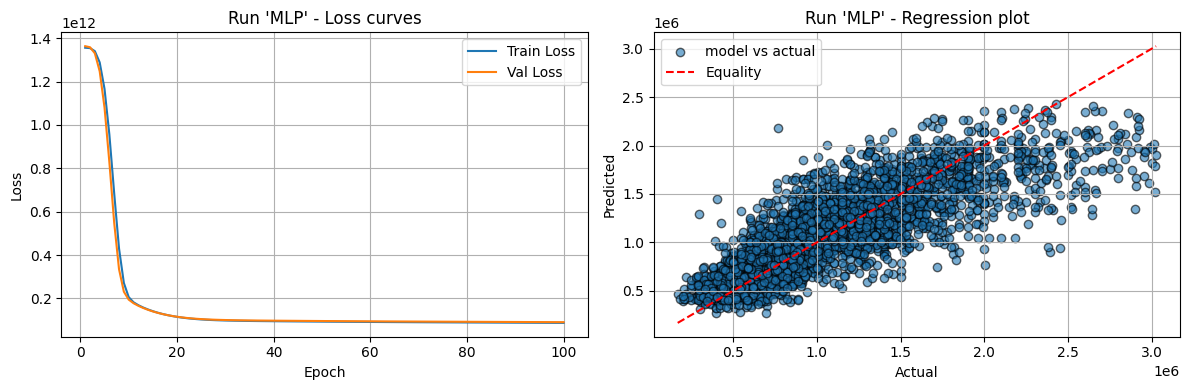

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax_loss = axs[0]
ax_reg = axs[1]

# Plot train and val loss
train_losses, val_losses = zip(*train_logs)
epochs = range(1, len(train_logs) + 1)

ax_loss.plot(epochs, train_losses, label="Train Loss")
ax_loss.plot(epochs, val_losses, label="Val Loss")
ax_loss.set_title(f"Run 'MLP' - Loss curves")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.legend()
ax_loss.grid(True)

# Regression plot: true vs predicted
ax_reg.scatter(y_test.squeeze(), test_output.squeeze(), alpha=0.6, edgecolor='k', label="model vs actual")
min_val = min(y_test.min(), test_output.min())
max_val = max(y_test.max(), test_output.max())
ax_reg.plot([min_val, max_val], [min_val, max_val], "r--", label="Equality")

ax_reg.set_title(f"Run 'MLP' - Regression plot")
ax_reg.set_xlabel("Actual")
ax_reg.set_ylabel("Predicted")
ax_reg.legend()
ax_reg.grid(True)

plt.tight_layout()

## Enhancer

In [16]:
train_data, train_target, train_spatial = (
    np.vstack((train_data, val_data)),
    np.concatenate((train_target, val_target)),
    np.vstack((train_spatial_pcs, val_spatial_pcs)),
)

In [17]:
train_ed = EnhancerData(
    from_numpy(train_data     .astype(np.float32)),
    from_numpy(train_target   .astype(np.float32)),
    from_numpy(train_spatial  .astype(np.float32)),
)

test_ed = EnhancerData(
    from_numpy(test_data     .astype(np.float32)),
    from_numpy(test_target   .astype(np.float32)),
    from_numpy(test_spatial  .astype(np.float32)),
)

In [18]:
train_config = TrainConfig(
    n_epochs=EPOCHS,
    learn_rate=LR,
    batch_size=BATCH_SIZE,
    loss_criteria=LOSS,
    val_ratio=0.2,
    test_ratio=0,
    node_vicinity=[10],
)

In [19]:
encoder = [
    (SAGEConv(train_ed.features.shape[1], 64), "x, edge_index -> x"),
    (ReLU(), "x -> x"),
    (Dropout(p=0.3), "x -> x"),
    (SAGEConv(64, 64), "x, edge_index -> x"),
    (ReLU(), "x -> x"),
    (Dropout(p=0.3), "x -> x"),
]

estimator = []
tmp = [64, *HIDDEN, 1]
for layer_in, layer_out in zip(tmp, tmp[1:]):
    estimator.append(Linear(layer_in, layer_out))
    estimator.append(ACTIVATION_T())

gnn_setup = NetworkConfig(
    encoder, estimator[:-1]
)

In [21]:
knn_strategy = encoders_module.KNNStrategy(
    K=20,
    dist_metric=euclid_metric,
    cache_dir=path_config.edge_cache / "melb",
    cache_id=f"KNN_20",
)

threshold_strategy = encoders_module.ThresholdStrategy(
    dist_metric=euclid_metric,
    max_dist=1,
    subsample_rate=0.5,
    cache_dir=path_config.edge_cache / "melb",
    cache_id=f"Threshold_1",
)

anchor_strategy = encoders_module.AnchorStrategy(
    n_repr=50,
    cluster_sample_rate=0.3,
    cache_dir=path_config.edge_cache / "melb",
    cache_id=f"Anchor_50",
)

grid_strategy = encoders_module.GridStrategy(
    intra_edge_ratio=0.2,
    source_inter_ratio=0.05,
    k_connectivity=5,
    bins=10,
    cache_dir=path_config.edge_cache / "melb",
    cache_id=f"Grid_5",
)

input_strategies = [
    knn_strategy,
    threshold_strategy,
    anchor_strategy,
    grid_strategy,
]

In [22]:
result = Enhancer.compare_strategies(
    train_ed,
    test_ed,
    gnn_setup,
    train_config,
    input_strategies,
)

GNN training: 100%|██████████| 100/100 [01:04<00:00,  1.55epoch/s, val_loss=7.75e+10]


In [23]:
from tabulate import tabulate
estimator = []
tmp = [64, *HIDDEN, 1]
for layer_in, layer_out in zip(tmp, tmp[1:]):
    estimator.append(Linear(layer_in, layer_out))
    estimator.append(ACTIVATION_T())

gnn_setup = NetworkConfig(
    encoder, estimator[:-1]
)

input_strategies = [
    knn_strategy,
    threshold_strategy,
    anchor_strategy,
    grid_strategy,
]

results = result.get_comparison([mean_squared_error, r2_score])
metrics_schema = list(results.values())[0].keys()
header = ["Option"] + list(metrics_schema)
rows = []
for option, measurements in results.items():
    rows.append([option, *measurements.values()])

print(tabulate(rows, headers=header))

Option         mean_squared_error    r2_score     density    average degree    n connected components    largest component
-----------  --------------------  ----------  ----------  ----------------  ------------------------  -------------------
KNN_20                1.0002e+11     0.64498   0.00151459           23.3429                         2                15324
Threshold_1           1.13512e+11    0.597087  0.127737           1968.55                           1                15412
Anchor_50             8.91013e+10    0.683735  0.0133092           205.122                         50                  711
Grid_5                1.24818e+11    0.556959  0.0170341           262.53                           1                15413


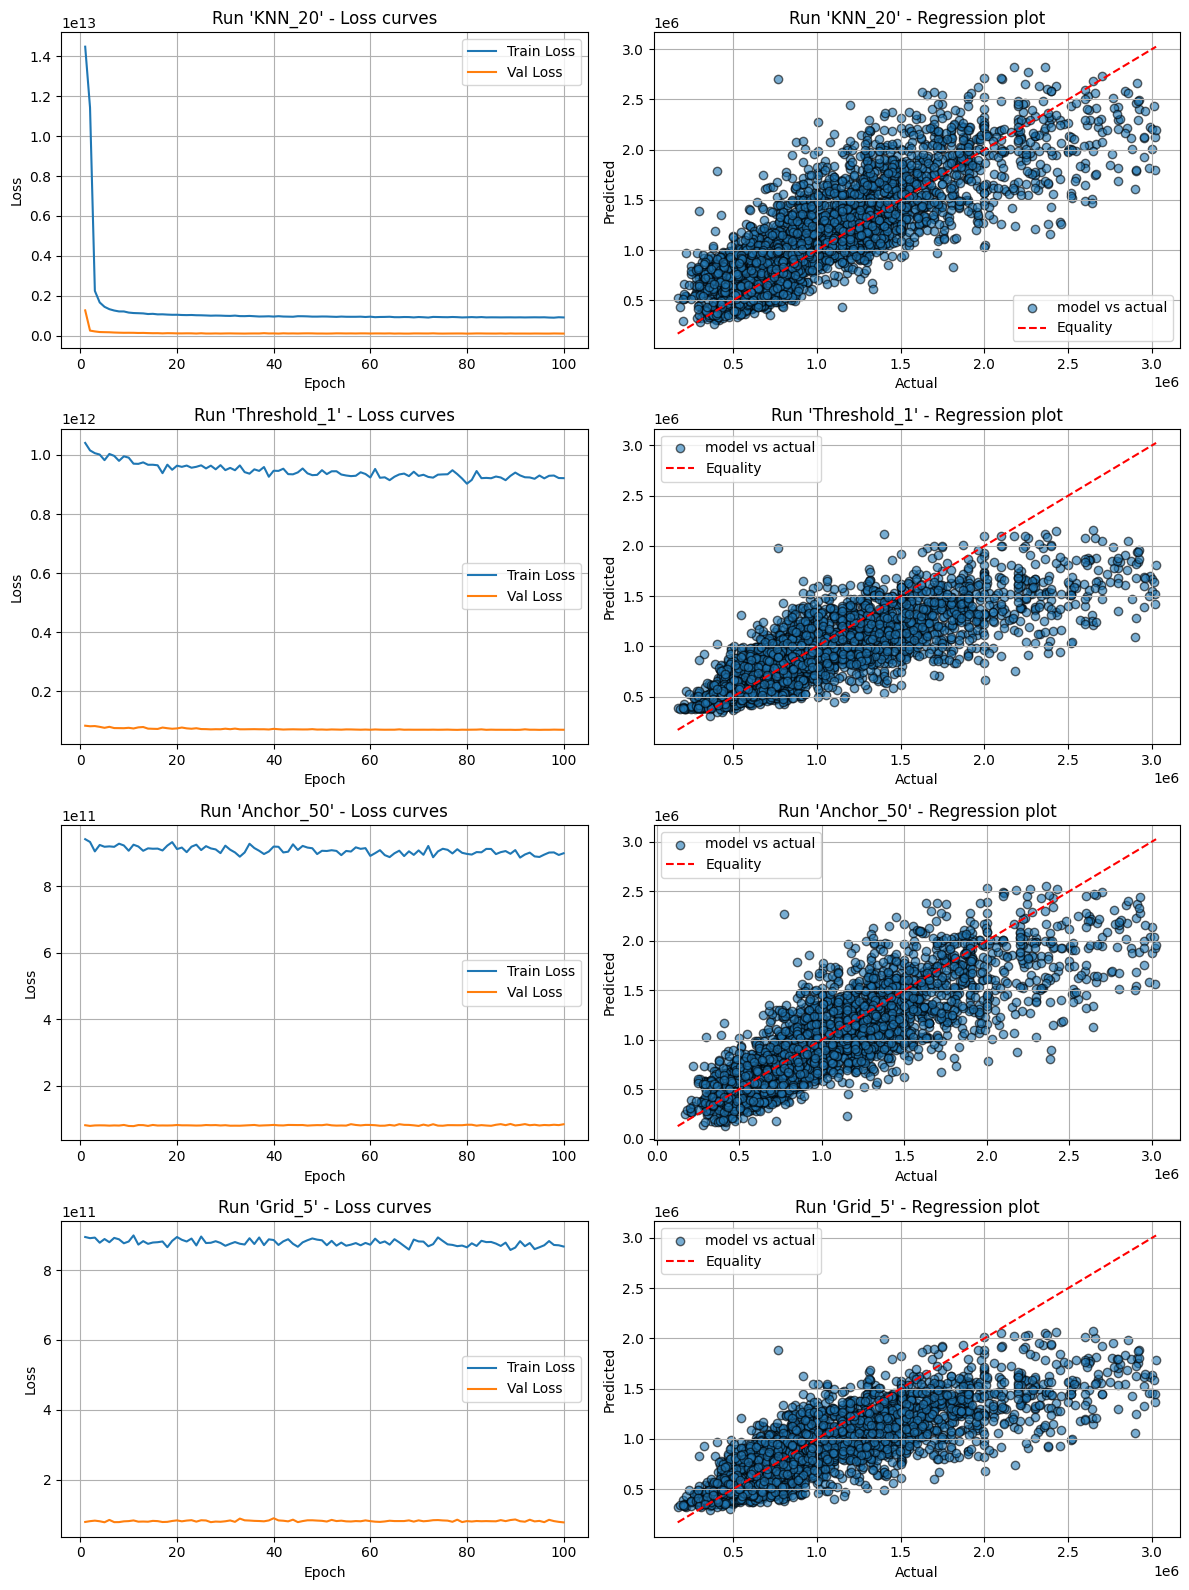

In [24]:
result.plot_train_logs(None)